<a href="https://colab.research.google.com/github/Gehlen05/mestrado-automacao/blob/main/algoritmo-engenharia/transformers_alexsandro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from foreblocks import TimeSeriesSeq2Seq, ModelConfig, TrainingConfig, AttentionLayer
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import matplotlib.pyplot as plt
from foreblocks import ForecastingModel
from foreblocks import LSTMDecoder, LSTMEncoder
from foreblocks import Trainer
from foreblocks.att import AttentionLayer
from foreblocks.blocks.fourier import FourierFeatures
from foreblocks import TransformerDecoder, TransformerEncoder

# 1) Ler CSV
df = pd.read_csv("timeseries.csv")

# 1) Limpar possíveis sujeiras no campo time
df["time"] = df["time"].astype(str).str.strip()

# remover linhas  inválidas (como "202", "", None)
df = df[~df["time"].isin(["202", "NaT", "", "nan", "None"])]

# converter para datetime (coerce => vira NaT se for inválida)
df["time"] = pd.to_datetime(df["time"], errors="coerce")

# remover datas inválidas
df = df.dropna(subset=["time"])

# 2) Remover NaNs do y e das features importantes
cols_to_clean = ["y"]

df = df.dropna(subset=cols_to_clean)

# 3) Filtrar só série 0
df0 = df[df["series"] == 0].copy()

# 4) Garantir ordenação por tempo
df0 = df0.sort_values("time").reset_index(drop=True)

print(df0.head())
print(df0.shape)


   series       time          y
0       0 2020-01-01   9.531467
1       0 2020-01-02  10.397162
2       0 2020-01-03  10.808862
3       0 2020-01-04  10.914430
4       0 2020-01-05  10.474456
(1500, 3)


In [ ]:
# 3) Escolher as FEATURES de entrada
#    IMPORTANTE: y tem que ser a PRIMEIRA coluna
feature_cols = [
    "y"

]

X = df0[feature_cols].to_numpy(dtype=float)
print("data shape:", X.shape)  # (n_samples, n_features)

data shape: (1500, 1)


In [ ]:
# ESSA PART FOI MANTIDA PARA FAZER A GERAÇÃO DE SEQUÊNCIA, NORMALIZAÇÃO E FILTROS
n_features = X.shape[1]
hidden_size=64
output_size=n_features
num_layers=1
model_config = ModelConfig(
    model_type="transformer",
    strategy="transformer_seq2seq",
    input_size=n_features,
    output_size=n_features,
    hidden_size=hidden_size,
    target_len=12
)

attention = AttentionLayer(
    method="mha",
    encoder_hidden_size=hidden_size,
    decoder_hidden_size=hidden_size
)

training_config = TrainingConfig(
    num_epochs=300,          # 👈 número de épocas

)

encoder = TransformerEncoder(
    input_size=n_features,                    # Number of features
)

decoder = TransformerDecoder(
    input_size=n_features,
    output_size=1,

)



fourier_preprocessor = FourierFeatures(
    input_size=n_features,          # Input dimension
    output_size=n_features,        # Output dimension (same as hidden_size)
    num_frequencies=16,             # Number of frequency components
    learnable=True,                 # Make frequency parameters learnable
    use_phase=False,                 # Include phase shifts
    use_gaussian=False,              # Use Gaussian random Fourier features (Rahimi & Recht)
)


In [ ]:
model = TimeSeriesSeq2Seq(
    model_config=model_config,
)


📊 [Auto-Configuration]

+--------------------+----------------+
|     Parameter      | Configuration  |
+--------------------+----------------+
| Dataset Dimensions |    1500 × 1    |
|   Missing Values   |     0.00%      |
|    Stationarity    | Non-stationary |
|    Seasonality     |    Present     |
|   Transformation   |      None      |
| Signal Processing  |     savgol     |
|     Imputation     |  interpolate   |
| Outlier Detection  |     tranad     |
| Outlier Threshold  |      3.50      |
|   Decomposition    |    5 bands     |
+--------------------+----------------+
✅ Configuration complete.



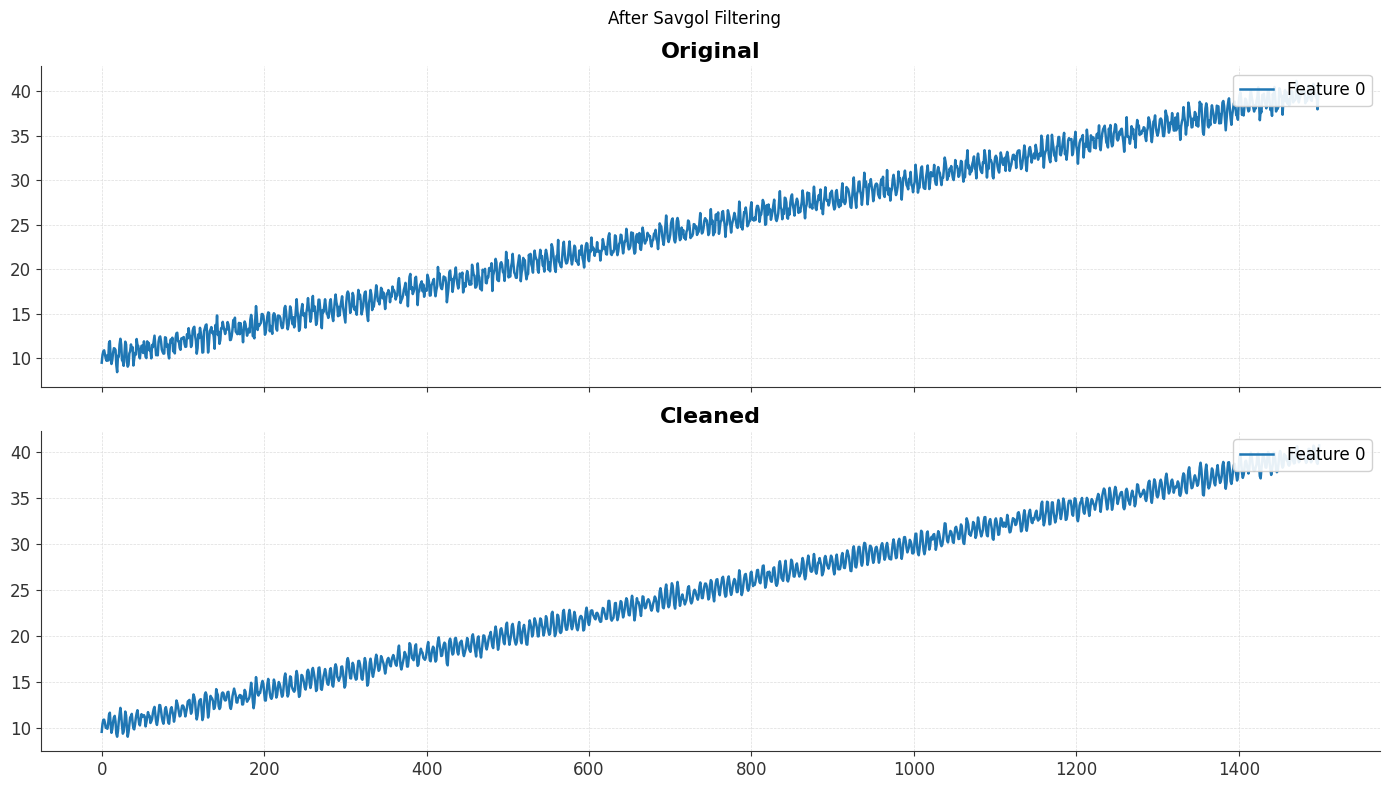

Creating sequences: 100%|██████████| 1457/1457 [00:00<00:00, 166003.88it/s]


In [ ]:
X_seq, y_seq, *_ = model.preprocess(
    X,
    normalize=True,
    differencing=True,
    detrend=True,
    apply_ewt=True,
    window_size=32,
    horizon=12,
    remove_outliers=False,
    outlier_method="iqr",
    self_tune=True,

)


In [ ]:
#Separação de dataset em treino 80% e teste 20%
N = len(X_seq)

train_end = int(0.8 * N)

X_train = X_seq[:train_end]
y_train = y_seq[:train_end]

X_test  = X_seq[train_end:]
y_test  = y_seq[train_end:]


In [ ]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)


X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

train_loader = DataLoader(
    TensorDataset(X_train, y_train),
    batch_size=32,
    shuffle=True
)


In [ ]:
import torch
from torch import nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)

        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (batch, seq_len, d_model)
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len]
        return self.dropout(x)


class FourierBlock(nn.Module):
    def __init__(self, d_model: int, k: int = 16):
        super().__init__()
        self.d_model = d_model
        self.k = k

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (batch, seq_len, d_model)
        x = x.transpose(1, 2)  # (batch, d_model, seq_len)

        x_ft = torch.fft.rfft(x, dim=-1)      # (batch, d_model, freq)
        k = min(self.k, x_ft.shape[-1])

        out_ft = torch.zeros_like(x_ft)
        out_ft[..., :k] = x_ft[..., :k]

        x = torch.fft.irfft(out_ft, n=x.shape[-1], dim=-1)
        x = x.transpose(1, 2)                 # (batch, seq_len, d_model)
        return x


class TimeSeriesTransformer(nn.Module):
    def __init__(
        self,
        input_size: int,      # número de features por passo
        target_len: int = 12, # horizonte de previsão
        output_size: int = 1, # n_targets (geralmente 1)
        d_model: int = 64,
        n_heads: int = 4,
        num_layers: int = 2,
        dropout: float = 0.1,
        use_fourier: bool = False,
    ):
        super().__init__()

        self.target_len = target_len
        self.output_size = output_size
        self.use_fourier = use_fourier

        self.input_proj = nn.Linear(input_size, d_model)

        if use_fourier:
            self.fourier = FourierBlock(d_model=d_model, k=min(16, d_model))

        self.pos_encoder = PositionalEncoding(d_model=d_model, dropout=dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True,  # usa (batch, seq, feature)
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # mapeia último hidden -> (target_len * output_size)
        self.fc_out = nn.Linear(d_model, target_len * output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (batch, seq_len=64, input_size)
        retorno: (batch, target_len=12, output_size)
        """
        B = x.size(0)

        x = self.input_proj(x)  # (B, L, d_model)

        if self.use_fourier:
            x = self.fourier(x)

        x = self.pos_encoder(x)
        h = self.encoder(x)     # (B, L, d_model)

        h_last = h[:, -1, :]    # (B, d_model) usa o último passo
        out = self.fc_out(h_last)  # (B, target_len * output_size)

        out = out.view(B, self.target_len, self.output_size)
        return out


In [ ]:
n_features = X_seq.shape[2]

model = TimeSeriesTransformer(
    input_size=n_features,
    target_len=12,     # saída com 12 passos
    output_size=1,     # univariado
    d_model=64,
    n_heads=4,
    num_layers=1,
    dropout=0.1,
    use_fourier=False,  # True ou False
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()


In [ ]:
num_epochs = 300

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for X_b, y_b in train_loader:
        X_b = X_b.to(device)              # (batch, 64, n_features)
        y_b = y_b.to(device)              # (batch, 12, 1)


        optimizer.zero_grad()

        y_pred = model(X_b)               # (batch, 12, 1)
        loss = criterion(y_pred, y_b)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_b.size(0)

    epoch_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - loss: {epoch_loss:.4f}")


Epoch 1/300 - loss: 0.8302


Epoch 2/300 - loss: 0.6009
Epoch 3/300 - loss: 0.4048
Epoch 4/300 - loss: 0.3652
Epoch 5/300 - loss: 0.3505
Epoch 6/300 - loss: 0.3325
Epoch 7/300 - loss: 0.3268
Epoch 8/300 - loss: 0.3152
Epoch 9/300 - loss: 0.3170
Epoch 10/300 - loss: 0.3133
Epoch 11/300 - loss: 0.3047
Epoch 12/300 - loss: 0.3080
Epoch 13/300 - loss: 0.3113
Epoch 14/300 - loss: 0.3039
Epoch 15/300 - loss: 0.3035
Epoch 16/300 - loss: 0.3021
Epoch 17/300 - loss: 0.2990
Epoch 18/300 - loss: 0.3026
Epoch 19/300 - loss: 0.3023
Epoch 20/300 - loss: 0.2999
Epoch 21/300 - loss: 0.2974
Epoch 22/300 - loss: 0.2937
Epoch 23/300 - loss: 0.3011
Epoch 24/300 - loss: 0.2992
Epoch 25/300 - loss: 0.2932
Epoch 26/300 - loss: 0.2950
Epoch 27/300 - loss: 0.3000
Epoch 28/300 - loss: 0.2963
Epoch 29/300 - loss: 0.2949
Epoch 30/300 - loss: 0.2878
Epoch 31/300 - loss: 0.2949
Epoch 32/300 - loss: 0.2895
Epoch 33/300 - loss: 0.2866
Epoch 34/300 - loss: 0.2928
Epoch 35/300 - loss: 0.2979
Epoch 36/300 - loss: 0.2901
Epoch 37/300 - loss: 0.2925


In [ ]:
import numpy as np
import torch

model.eval()

y_true_vec = []
y_pred_vec = []

for i in range(len(X_test)):
    x = torch.tensor(X_test[i], dtype=torch.float32).unsqueeze(0).to('cuda')
    y_true_vec.extend(y_test[i].reshape(-1).tolist())

    with torch.no_grad():
        y_pred = model(x).cpu().numpy().reshape(-1)

    y_pred_vec.extend(y_pred.tolist())

y_true_vec = np.array(y_true_vec)   # shape (292*12,)
y_pred_vec = np.array(y_pred_vec)   # shape (292*12,)


In [ ]:
mse_val  = np.mean((y_true_vec - y_pred_vec) ** 2)
rmse_val = np.sqrt(mse_val)

print(f"MSE validação : {mse_val:.4f}")
print(f"RMSE validação: {rmse_val:.4f}")


MSE validação : 0.2703
RMSE validação: 0.5199


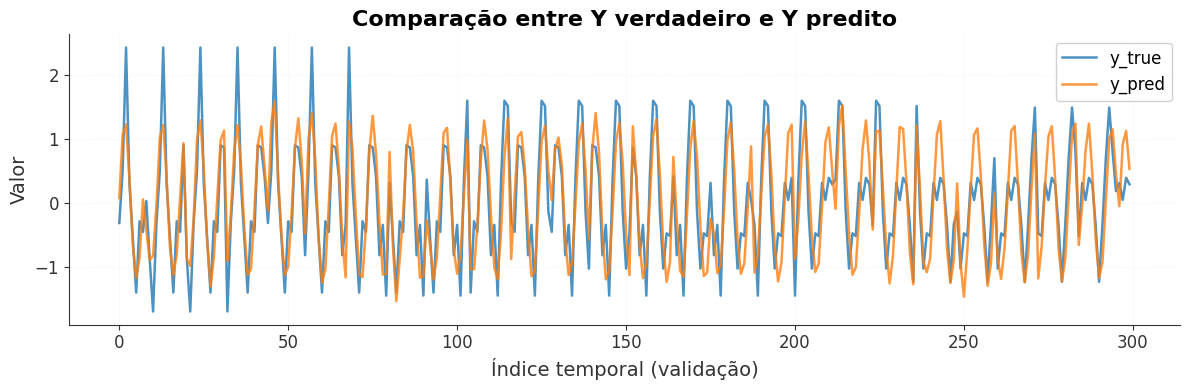

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(y_true_vec[700:1000], label="y_true", alpha=0.8)
plt.plot(y_pred_vec[700:1000], label="y_pred", alpha=0.8)

plt.title("Comparação entre Y verdadeiro e Y predito")
plt.xlabel("Índice temporal (validação)")
plt.ylabel("Valor")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


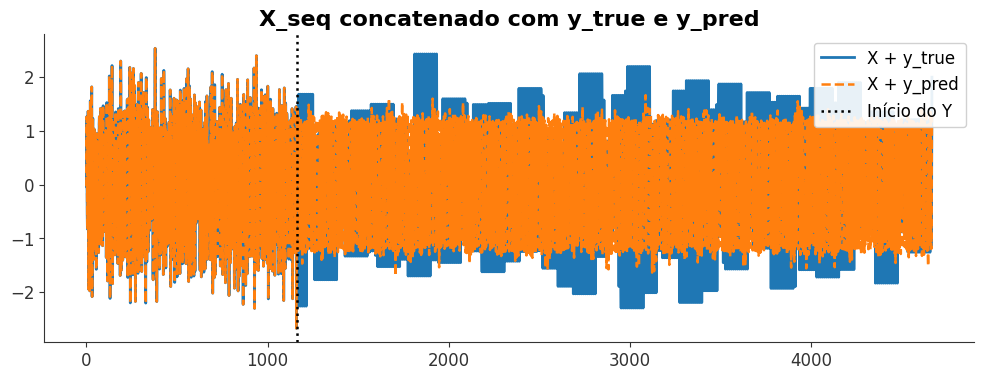

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# escolha da feature (se X_seq tiver 3D)
feature = 0

# sequência X completa até train_end
if X_seq.ndim == 3:
    x_plot = X_seq[:train_end, feature]
elif X_seq.ndim == 2:
    x_plot = X_seq[:train_end]
else:
    raise ValueError("Formato inesperado de X_seq")

# transformar em 1D para plot
x_plot = np.asarray(x_plot).reshape(-1)

# criar vector concatenado
joined_true  = np.concatenate([x_plot, y_true_vec])
joined_pred  = np.concatenate([x_plot, y_pred_vec])

plt.figure(figsize=(12,4))
plt.plot(joined_true, label="X + y_true", linewidth=2)
plt.plot(joined_pred, label="X + y_pred", linestyle="--")
plt.axvline(len(x_plot), color="black", linestyle=":", label="Início do Y")
plt.legend()
plt.grid()
plt.title("X_seq concatenado com y_true e y_pred")
plt.show()
